In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

#
import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy


## Extraer usuarios

In [2]:
# get users and mentions from the download files:
tweets_datas_path = ['dwnld_debate.json',
                     'dwnld_1.json',
                     'dwnld_2.json',
                     'dwnld_3.json']                    
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]

for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                mentioned_ids.append(list(set([ent["id_str"] for ent in tw_entities])))
                tw_text.append([tweet["id_str"],tw_text_loop])
            except:
                continue



    


In [3]:
print(len(tw_id),
      len(tw_user_id),
      len(tw_user),
      len(tw_text),
      len(entities_long),
      len(mentioned_ids))

272595 272595 272595 272577 1343096 272577


In [4]:
tweets_ids=pd.DataFrame({"tw_id":tw_id,
              "tw_user_id":tw_user_id,
              "tw_user":tw_user
             })
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 55812


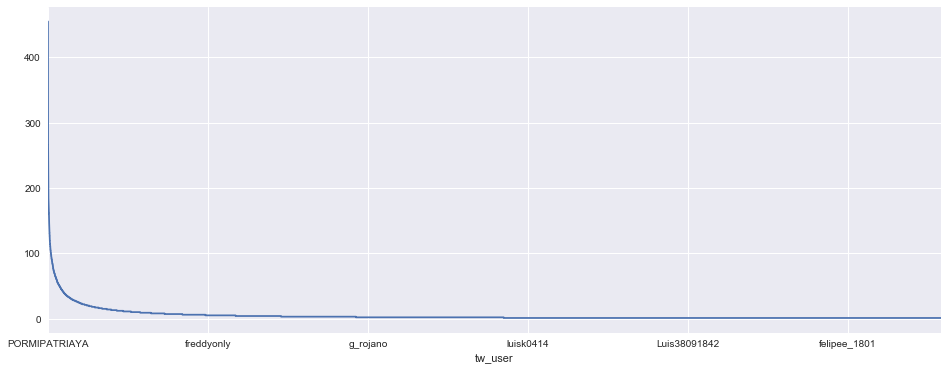

In [5]:
# ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
ids_freqs.plot(figsize=(16,6))

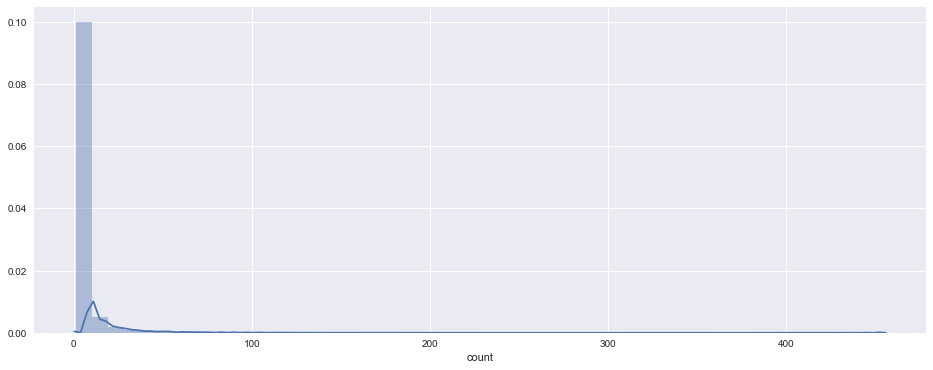

In [6]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [7]:
round(ids_freqs.describe(),3)

count    55812.000
mean         4.884
std         12.661
min          1.000
25%          1.000
50%          2.000
75%          4.000
max        455.000
Name: count, dtype: float64

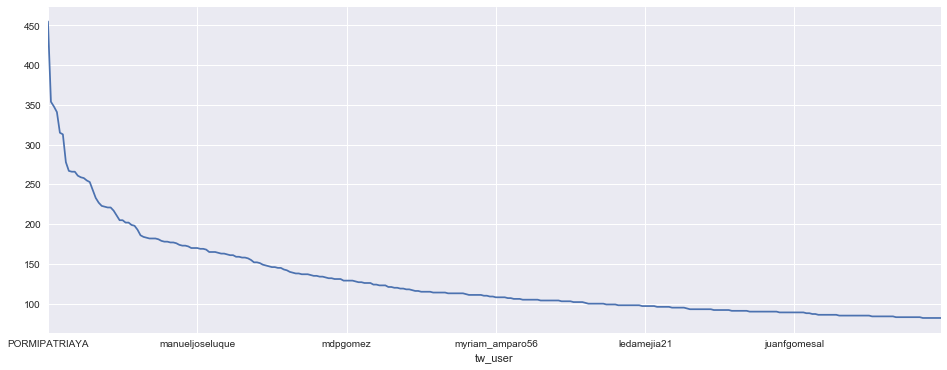

In [8]:
ids_freqs[:300].plot(figsize=(16, 6))

In [9]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
PORMIPATRIAYA      455
Yaniracolombia     354
NANACHAGU          348
Cmarcafederal      341
marco_caldon       315
valderramaangel    313
abel3131           278
nenoriega5         267
VotaPorGerman      266
TWITERM99417410    266
GladysBecerra1     261
DieGatto1          259
AbCarrymar         258
lguzmangomez       255
biolucho2005       253
CarrillonavasG     243
waltermunevar      233
megavas            227
LuisCarlosFV2      223
lugicas            222
MACMontt           221
pierrealee         221
ramiropinzon56     217
krlosgiraldo1      211
SGTBerkoff1981     205
DavidMed_          205
Kinopodia          202
Gustavo68831299    202
jjolivella         199
ZONAALEX9864       198
GusDuque1          193
josecastano0904    186
Santifer57         184
MiguelS69397877    183
carlucas956666     182
jklosan05          182
jose_amed          182
HernanChelo        181
VancliffDesign     179
luisvarela888      178
VictoriaRubian5    178
noelquisa          177
JaviJimenezl       177
PAU

In [27]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

19256

In [11]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [12]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 19270


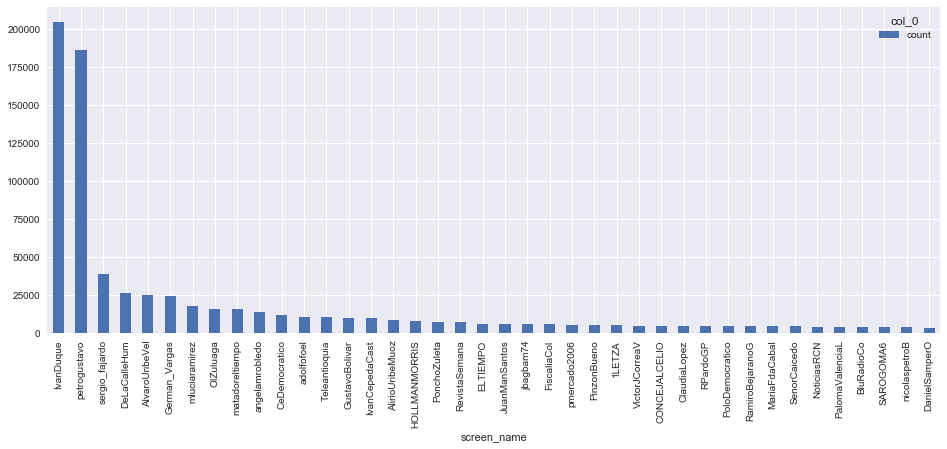

In [13]:
ments_freq[:40].plot(kind='bar', figsize=(16,6))

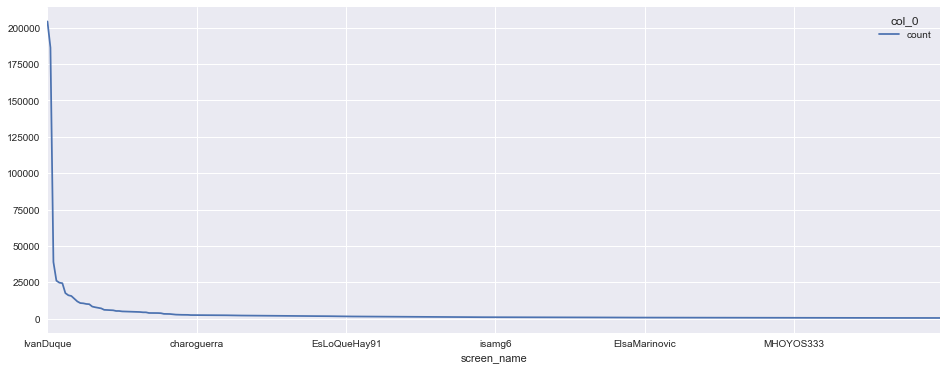

In [41]:
ments_freq[:300].plot(figsize=(16, 6))

In [44]:
(ments_freq[:300])#40

col_0,count
screen_name,
IvanDuque,204310
petrogustavo,186318
sergio_fajardo,38963
DeLaCalleHum,26131
AlvaroUribeVel,24753
German_Vargas,24389
mluciaramirez,17596
OIZuluaga,16114
matadoreltiempo,15612


# Verificar Loop
# * Usar One Hot Encoding

### Clustering Candidatos

In [49]:
scr_nm_cands=["DeLaCalleHum", "ClaraLopezObre",
              "MoralesViviane",
              "sergio_fajardo","ClaudiaLopez",
              "VotoenblancoCo",
              "piedadcordoba","JaimeAraujoR",
              "prjorgetrujillo",
              "German_Vargas","PinzonBueno",
              "IvanDuque","mluciaramirez",
              "petrogustavo","angelamrobledo"
              ]

#[ments_df.loc[ments_df.screen_name==nm_cand].iloc[0:1,0] for nm_cand in scr_nm_cands]
id_str_cand=["823348278830002177","126832572",
             "86622012",
             "25185308","137908875",
             "910144193586188288",
             "34798360","2542586322",
             "232344683",
             "20456814","3401638840",
             "77653794","198984928",
             "49849732","165748292"
             ]

cands_mntns=np.array([[cand in tw_mntns for cand in id_str_cand]for tw_mntns in mentioned_ids])
cands_mntns.shape


(272577, 15)

In [67]:
pd.DataFrame([[cand in tw_mntns for cand in id_str_cand]for tw_mntns in mentioned_ids[21550:21560]])
#[[cand in tw_mntns for cand in id_str_cand]for tw_mntns in [mentioned_ids[21558]]]
#[mentioned_ids[21558]]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
5,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False
6,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
8,True,False,False,True,False,False,False,False,False,True,False,True,False,True,False
9,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [68]:
mentioned_ids[21558]

['25185308',
 '823348278830002177',
 '77653794',
 '18079284',
 '20456814',
 '60619634',
 '57174405',
 '49849732']

In [17]:
df_cands_mntns=pd.DataFrame(cands_mntns,columns=scr_nm_cands)

IvanDuque          129283
petrogustavo       117290
sergio_fajardo      25589
DeLaCalleHum        16616
German_Vargas       15615
mluciaramirez       12458
angelamrobledo       9290
ClaudiaLopez         3377
PinzonBueno          3242
piedadcordoba        1044
ClaraLopezObre        818
MoralesViviane        543
JaimeAraujoR           13
VotoenblancoCo          2
prjorgetrujillo         0
dtype: int64


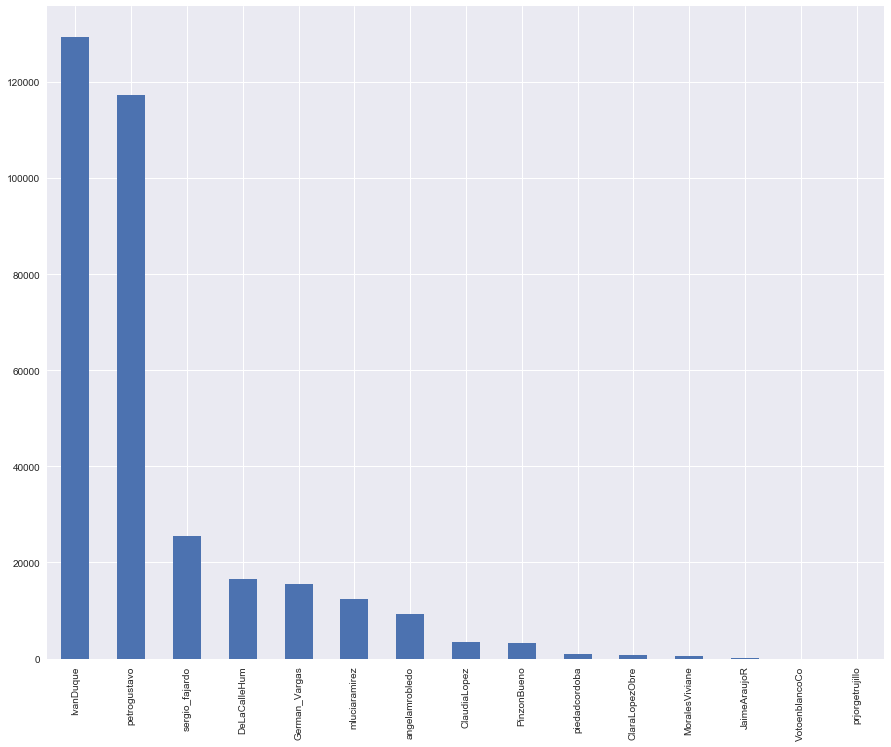

In [50]:
plt.figure(figsize=(15,12))
print (df_cands_mntns.sum(axis=0).sort_values(ascending=False))
df_cands_mntns.sum(axis=0).sort_values(ascending=False).plot(kind="bar")

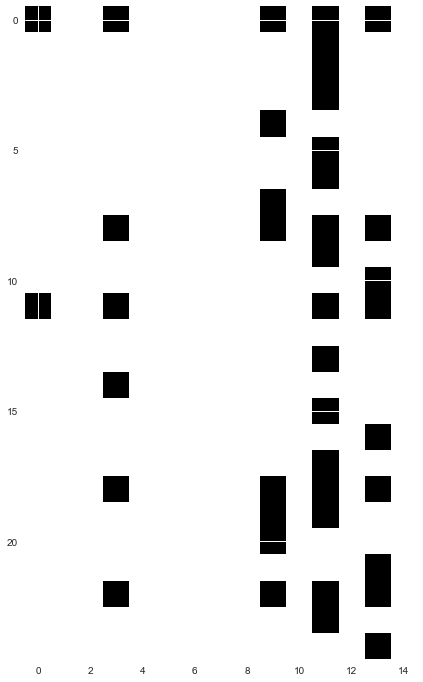

In [19]:
plt.figure(figsize=(15,12))
plt.imshow(df_cands_mntns.iloc[:25,:], cmap=plt.cm.gray_r, interpolation='nearest')

In [23]:
cands_ward= hierarchy.linkage(df_cands_mntns.transpose(), 'ward')

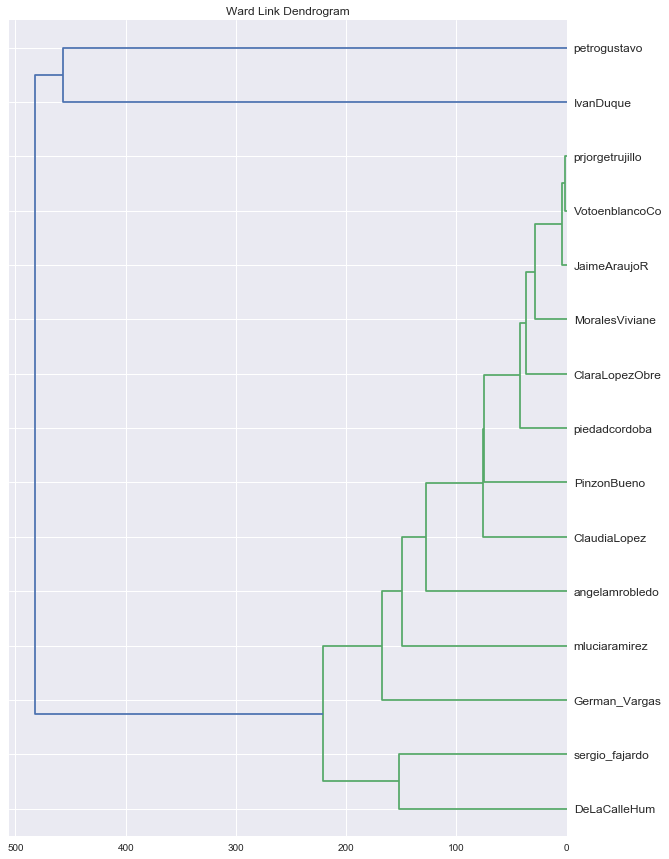

In [24]:
#max_d = 10
plt.figure(figsize=(10,15))
#plt.figure()
dn = hierarchy.dendrogram(cands_ward,orientation="left", labels=scr_nm_cands)
#plt.axhline(y=max_d, c='k')
plt.title('Ward Link Dendrogram')
#plt.savefig('dendrograma_ward_link.jpg')
plt.show()

### Clustering Nexos

In [46]:
ments_sel=list(ments_freq[:300].index)

In [47]:
mntns_mtrx=np.array([[cand in tw_mntns for cand in ments_sel]for tw_mntns in ments_df.screen_name])


In [48]:
df_mntns_mtrx=pd.DataFrame(mntns_mtrx,columns=ments_sel)